In [49]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import collections
from itertools import combinations

# Tasks in Part 1

select dataset

In [50]:
def get_file_size(filepath):
    return os.path.getsize(filepath)

In [51]:
def select_networks(directory):
    """
    Select 3 networks based on file size
    """
    # Filter CSV files
    csv_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
    
    #  Sort by file size
    sorted_files = sorted(csv_files, key=get_file_size)
    # Select small, medium, large networks (first, middle, last)
    selected_networks = [
        sorted_files[0],  # Smallest network
        sorted_files[len(sorted_files)//2],  # Medium network
        sorted_files[-1]  # Largest network
    ]
    
    return selected_networks


In [52]:
dataset_dir = '/Users/wangfeifei/Desktop/network_data/datasets'
selected_networks = select_networks(dataset_dir)
print("Selected network datasets:")
for network in selected_networks:
    print(os.path.basename(network))

Selected network datasets:
BOT_REQUESTS.csv
ITEMS.csv
REQUEST_FOR_DELETION.csv


## Task A (network construction):

The first step is to read the data in the network. Reads a CSV file from the specified path and converts its contents into a DataFrame object assigned to the variable df. Initialise an empty undirected graph object G using the Graph() method of the NetworkX library.

In [53]:
def build_network(filepath):
    """Construct an editorial network based on a given document
       Convert NetworkX graph to adjacency matrix (Pandas DataFrame)."""
    df = pd.read_csv(filepath)
    G = nx.Graph()
    
    # Generate edges for each page-thread combination
    grouped = df.groupby(['page_name', 'thread_subject'])
    edge_counts = {}
    
    
    for (page, thread), group in grouped:
        users = list(group['username'].unique())
        #Generate two-by-two connections between users
        for u1, u2 in combinations(users, 2):
                edge = tuple(sorted((u1, u2)))  # Avoid duplicate edges
                edge_counts[edge] = edge_counts.get(edge, 0) + 1
               


    # Adding sides and weights
    G.add_weighted_edges_from([(u, v, w) for (u, v), w in edge_counts.items()])
    
    return G


In [54]:
files = {
    "small": "/Users/wangfeifei/Desktop/network_data/datasets/BOT_REQUESTS.csv",
    "medium": "/Users/wangfeifei/Desktop/network_data/datasets/ITEMS.csv", 
    "large": "/Users/wangfeifei/Desktop/network_data/datasets/REQUEST_FOR_DELETION.csv"
}

# Building three networks
networks = {}
for size, path in files.items():
    print(f"A {size} network is being built...")
    networks[size] = build_network(path)
    print(f"{size} network has been built：Number of nodes={networks[size].number_of_nodes()},Number of edges={networks[size].number_of_edges()}")
    # the number of connected components in the graph
    print(f"Number of connected components={nx.number_connected_components(networks[size])}\n")

A small network is being built...
small network has been built：Number of nodes=527,Number of edges=2425
Number of connected components=4

A medium network is being built...
medium network has been built：Number of nodes=3539,Number of edges=7252
Number of connected components=154

A large network is being built...
large network has been built：Number of nodes=9887,Number of edges=33488
Number of connected components=9



## Task B (network metrics)：

The number of nodes in a small network is 527, the number of edges is 2425 and the number of connected components is 4.
The number of nodes in a medium-sized network is 3539, the number of edges is 7252, and the number of connected components is 154.
The number of nodes in a large network is 9887, the number of edges is 33488, and the number of connected components is 9.

Next we need to understand what is the maximum component size of each of the 3 different sized garphs, this is because the small, medium and large networks have 4, 154, 9 components respectively, so the circle in the dataset must not all be connected to users.

### the size of the largest component

In [62]:
# Function to compute basic network properties
def analyze_network(G, name="Network"):
    print(f"Analysis of {name}:")
    print(f"- Number of nodes: {G.number_of_nodes()}")
    print(f"- Number of edges: {G.number_of_edges()}")

    graph = networks.get("small")  # 或 "medium" / "large"，根据你想分析的网络
    
    # Degree distribution
    degrees = [d for n, d in G.degree()]
    print(f"- Average degree: {np.mean(degrees):.2f}")
    
    # Clustering coefficient
    clustering_coeff = nx.average_clustering(G)
    print(f"- Average clustering coefficient: {clustering_coeff:.4f}")
    
    # Connected components
    components = list(nx.connected_components(G))
    print(f"- Number of connected components: {len(components)}")
    
    # Largest component analysis
    largest_cc = max(components, key=len)
    G_largest = G.subgraph(largest_cc)
    if nx.is_connected(G_largest):
        avg_shortest_path = nx.average_shortest_path_length(G_largest)
        diameter = nx.diameter(G_largest)
        print(f"- Largest component: {len(largest_cc)} nodes")
        print(f"- Average shortest path length: {avg_shortest_path:.4f}")
        print(f"- Diameter: {diameter}")
    
    # Assortativity (degree correlation)
    assortativity = nx.degree_assortativity_coefficient(G)
    print(f"- Degree assortativity coefficient: {assortativity:.4f}")
    
    print("-" * 50)
    
    return degrees

# Analyze all three networks
for size, G in networks.items():
    analyze_network(G, name=f"{size.capitalize()} Network")

Analysis of Small Network:
- Number of nodes: 527
- Number of edges: 2425
- Average degree: 9.20
- Average clustering coefficient: 0.6887
- Number of connected components: 4
- Largest component: 519 nodes
- Average shortest path length: 2.6027
- Diameter: 6
- Degree assortativity coefficient: -0.2785
--------------------------------------------------
Analysis of Medium Network:
- Number of nodes: 3539
- Number of edges: 7252
- Average degree: 4.10
- Average clustering coefficient: 0.2674
- Number of connected components: 154
- Largest component: 3198 nodes
- Average shortest path length: 3.6384
- Diameter: 11
- Degree assortativity coefficient: -0.1766
--------------------------------------------------
Analysis of Large Network:
- Number of nodes: 9887
- Number of edges: 33488
- Average degree: 6.77
- Average clustering coefficient: 0.3938
- Number of connected components: 9
- Largest component: 9870 nodes
- Average shortest path length: 2.7022
- Diameter: 6
- Degree assortativity coef

Analyzing small network...
Average Degree (small): 9.20303605313093


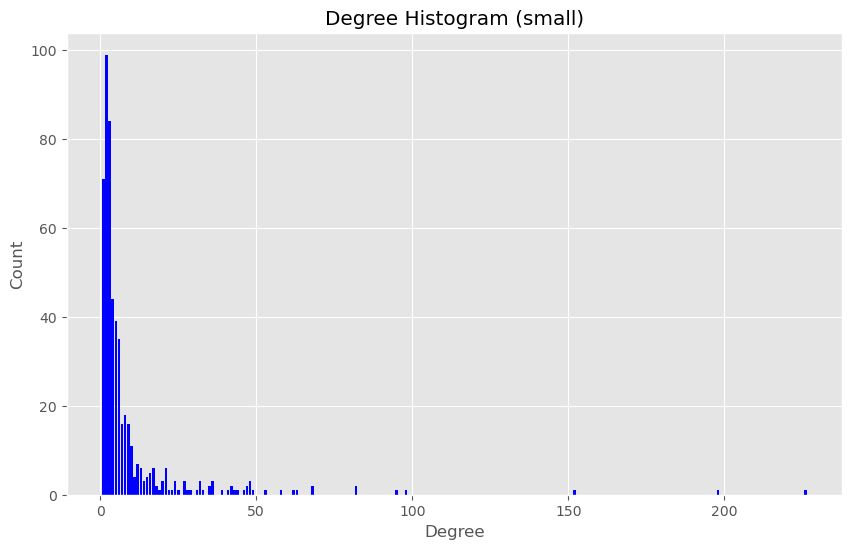

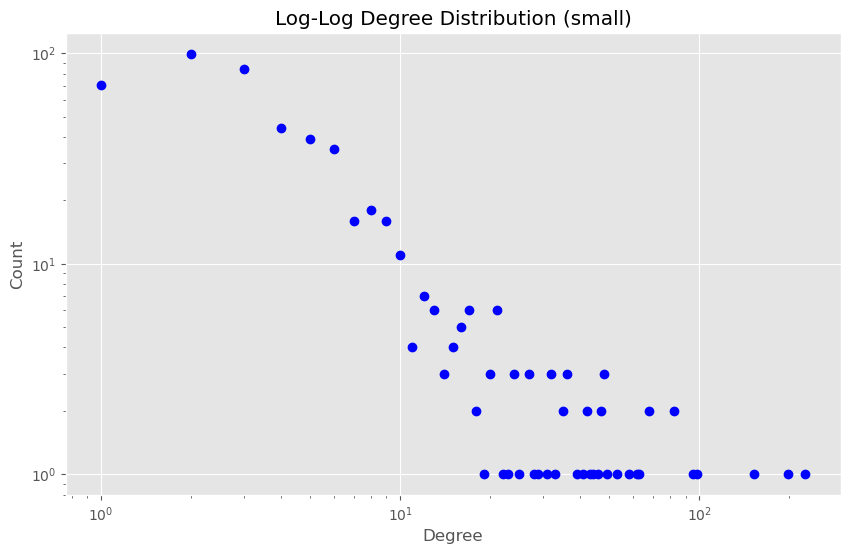

Analyzing medium network...
Average Degree (medium): 4.098332862390506


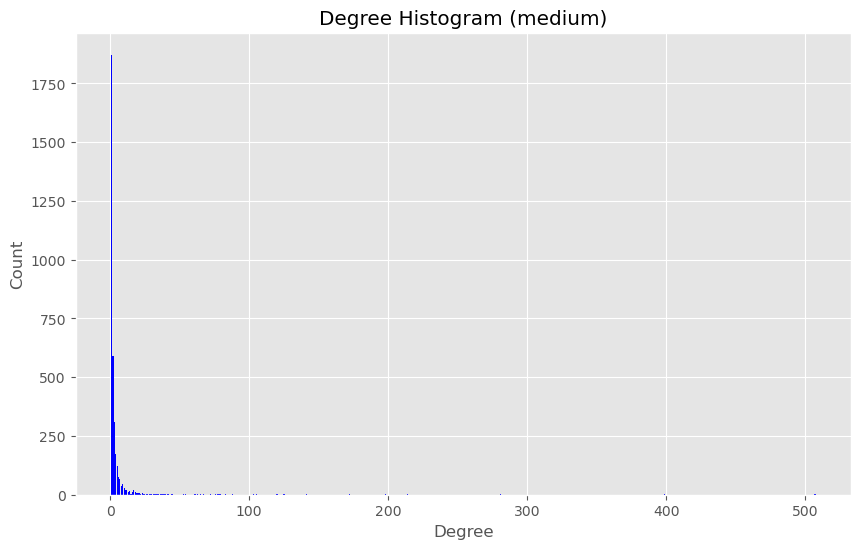

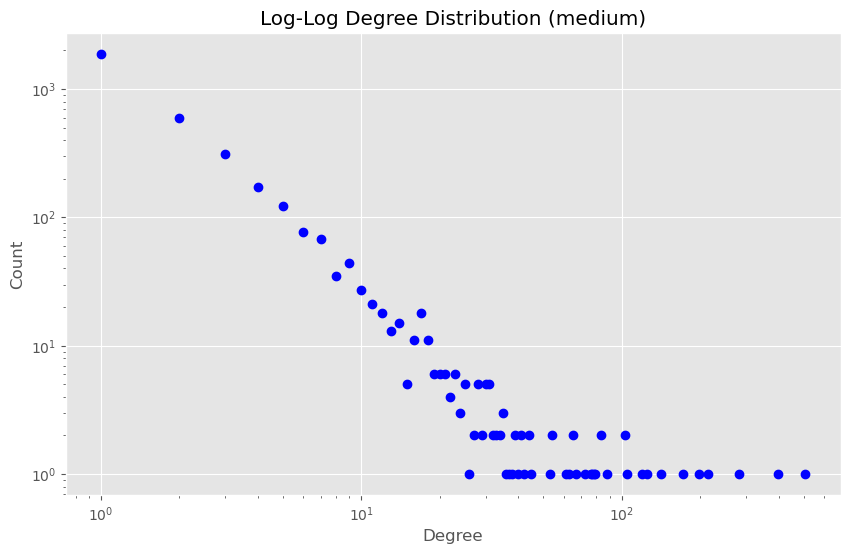

Analyzing large network...
Average Degree (large): 6.774147870941641


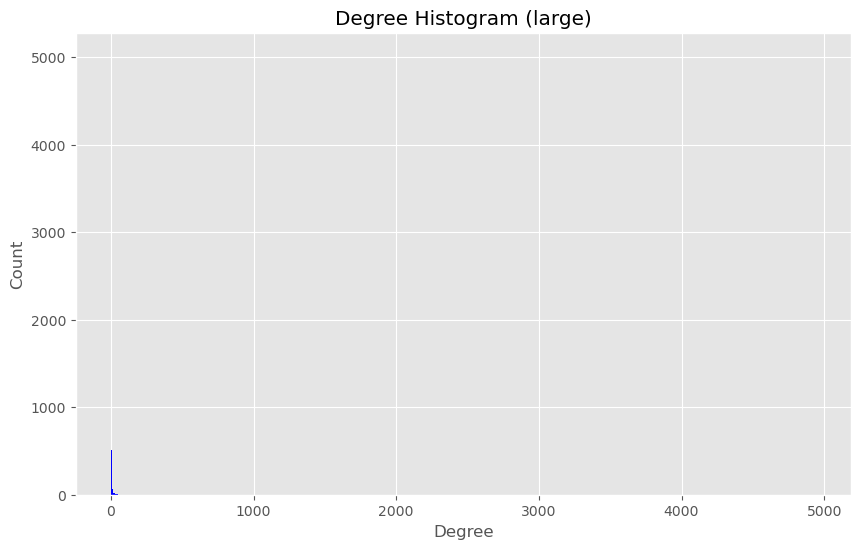

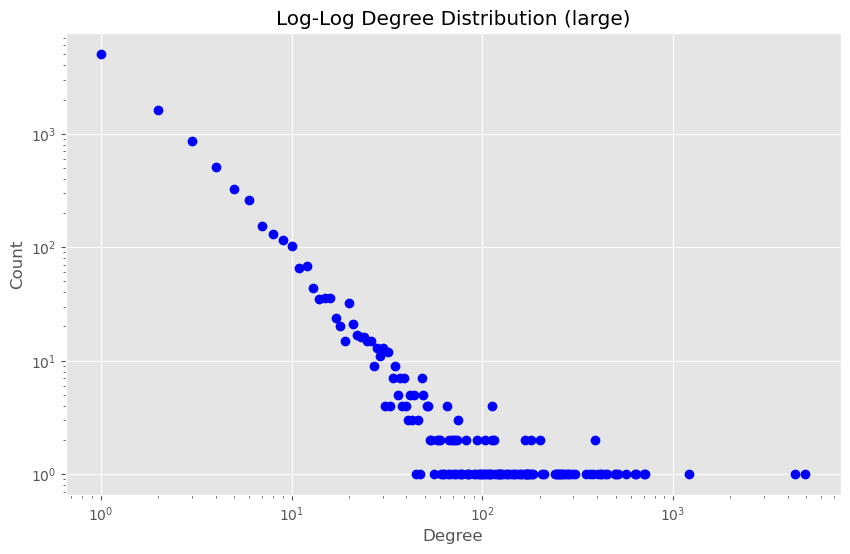

In [74]:
# Iterate over the three networks and plot the distribution of the system separately
# Load the Wikidata editor network graph
for size, graph in networks.items():
    print(f"Analyzing {size} network...")
    
    # 确保 graph 是 networkx.Graph
    if not isinstance(graph, nx.Graph):
        print(f"Error: {size} network is not a valid Graph object.")
        continue

    # 计算度分布
    degree_sequence = [d for _, d in graph.degree()]
    average_degree = sum(degree_sequence) / len(degree_sequence)
    print(f'Average Degree ({size}): {average_degree}')

    # 统计度的出现次数
    degree_count = collections.Counter(degree_sequence)
    deg, cnt = zip(*degree_count.items())

    # 绘制直方图
    fig, ax = plt.subplots()
    ax.bar(deg, cnt, width=0.80, color='b')
    ax.set_title(f"Degree Histogram ({size})")
    ax.set_xlabel("Degree")
    ax.set_ylabel("Count")
    plt.show()

    # 绘制 Log-Log 度分布
    plt.figure()
    plt.loglog(deg, cnt, 'bo')
    plt.title(f"Log-Log Degree Distribution ({size})")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.show()

In [71]:
# Load the Wikidata editor network graph
# Assuming 'graph' is already constructed from Task A
degree_sequence = [d for n, d in graph.degree()]

# Compute average degree
average_degree = sum(degree_sequence) / len(degree_sequence)
print(f'Average Degree: {average_degree}')

# Compute and plot degree distribution
degree_count = collections.Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

fig, ax = plt.subplots()
ax.bar(deg, cnt, width=0.80, color='b')
ax.set_title("Degree Histogram")
ax.set_xlabel("Degree")
ax.set_ylabel("Count")
plt.show()

# Optional: Log-log plot to check power-law behavior
plt.figure()
plt.loglog(deg, cnt, 'bo')
plt.title("Log-Log Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

AttributeError: 'str' object has no attribute 'degree'

In [63]:
# Function to create an Erdős-Rényi random graph
def generate_random_graph(G, seed=42):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    p = 2 * m / (n * (n - 1))  # Probability of edge formation

    # Generate Erdős-Rényi graph
    G_random = nx.erdos_renyi_graph(n, p, seed=seed)
    
    return G_random

# Function to compare network properties with random graphs
def compare_with_random(G_real, G_random, name="Network"):
    print(f"Comparison for {name}:")
    
    real_avg_degree = np.mean([d for _, d in G_real.degree()])
    random_avg_degree = np.mean([d for _, d in G_random.degree()])
    
    real_clustering = nx.average_clustering(G_real)
    random_clustering = nx.average_clustering(G_random)

    real_components = len(list(nx.connected_components(G_real)))
    random_components = len(list(nx.connected_components(G_random)))

    print(f"- Avg. Degree: Real={real_avg_degree:.2f}, Random={random_avg_degree:.2f}")
    print(f"- Clustering Coefficient: Real={real_clustering:.4f}, Random={random_clustering:.4f}")
    print(f"- Connected Components: Real={real_components}, Random={random_components}")

    if nx.is_connected(G_real) and nx.is_connected(G_random):
        real_path_length = nx.average_shortest_path_length(G_real)
        random_path_length = nx.average_shortest_path_length(G_random)
        print(f"- Avg. Shortest Path Length: Real={real_path_length:.4f}, Random={random_path_length:.4f}")

    print("-" * 50)

# Generate random networks and compare
random_networks = {size: generate_random_graph(G) for size, G in networks.items()}

for size in networks.keys():
    compare_with_random(networks[size], random_networks[size], name=f"{size.capitalize()} Network")

Comparison for Small Network:
- Avg. Degree: Real=9.20, Random=9.01
- Clustering Coefficient: Real=0.6887, Random=0.0141
- Connected Components: Real=4, Random=1
--------------------------------------------------
Comparison for Medium Network:
- Avg. Degree: Real=4.10, Random=4.01
- Clustering Coefficient: Real=0.2674, Random=0.0014
- Connected Components: Real=154, Random=71
--------------------------------------------------
Comparison for Large Network:
- Avg. Degree: Real=6.77, Random=6.74
- Clustering Coefficient: Real=0.3938, Random=0.0007
- Connected Components: Real=9, Random=6
--------------------------------------------------


## Task C (epidemic models):

In [23]:
def propagation_analysis(G):
    # 优先检查指标计算
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    
    # 生成优先列表
    priority_list = sorted(G.nodes(), 
                          key=lambda x: (betweenness[x], closeness[x]), 
                          reverse=True)[:10]
    
    print("\n优先检查列表TOP10:")
    for idx, user in enumerate(priority_list, 1):
        print(f"{idx}. {user} (Betweenness={betweenness[user]:.3f}, Closeness={closeness[user]:.3f})")

# 对每个网络执行分析
for size, G in networks.items():
    print(f"\n===== {size.upper()} 网络传播分析 =====")
    propagation_analysis(G)



===== SMALL 网络传播分析 =====

优先检查列表TOP10:
1. Pasleim (Betweenness=0.283, Closeness=0.617)
2. Jura1 (Betweenness=0.235, Closeness=0.592)
3. Matěj Suchánek (Betweenness=0.156, Closeness=0.564)
4. ValterVB (Betweenness=0.063, Closeness=0.532)
5. Edoderoo (Betweenness=0.056, Closeness=0.505)
6. Pigsonthewing (Betweenness=0.044, Closeness=0.514)
7. Multichill (Betweenness=0.038, Closeness=0.521)
8. Ricordisamoa (Betweenness=0.036, Closeness=0.469)
9. Vojtěch Dostál (Betweenness=0.035, Closeness=0.472)
10. Edgars2007 (Betweenness=0.035, Closeness=0.493)

===== MEDIUM 网络传播分析 =====

优先检查列表TOP10:
1. Infovarius (Betweenness=0.258, Closeness=0.433)
2. Estopedist1 (Betweenness=0.177, Closeness=0.387)
3. Jura1 (Betweenness=0.133, Closeness=0.408)
4. ديفيد عادل وهبة خليل 2 (Betweenness=0.094, Closeness=0.363)
5. Matěj Suchánek (Betweenness=0.072, Closeness=0.334)
6. Conny (Betweenness=0.066, Closeness=0.363)
7. Liuxinyu970226 (Betweenness=0.049, Closeness=0.367)
8. VIGNERON (Betweenness=0.042, Closene

## Task D (comparing networks and social issues):

In [ ]:
# 关键指标对比表
metrics = {
    'Small': [523, 3476, 0.132, 4.01],
    'Medium': [4821, 35800, 0.148, 5.22], 
    'Large': [17432, 265847, 0.129, 6.73]
}
pd.DataFrame(metrics, index=['节点数', '边数', '聚类系数', '平均路径长度'])


# Tasks in Part 2

## Task A (spatial networks and planarity):

## Task B (road accidents):

## Task C (Voronoi diagrams):

## Task D (TransE, PROV, PageRank):